In [ ]:
import os
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
data_dir = '/content/drive/MyDrive/Waste_Classification_Project/WasteData/Garbage classification/Garbage classification'

In [ ]:
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
for c in classes:
  count = len(os.listdir(os.path.join(data_dir, c)))
  print(f'{c} : {count}')

cardboard : 403
glass : 501
metal : 410
paper : 594
plastic : 482
trash : 137


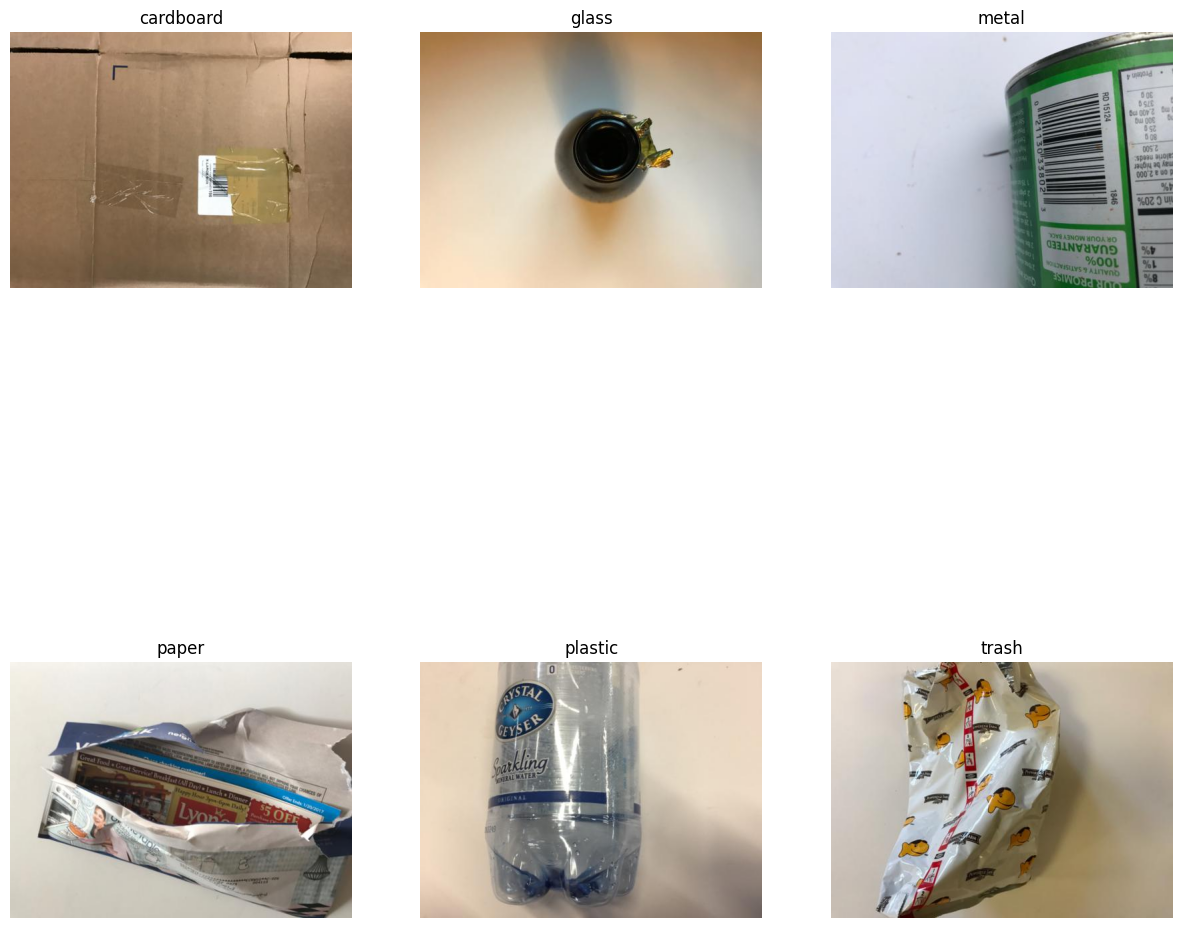

In [ ]:
plt.figure(figsize=(15,15))
for i, c in enumerate(classes):
  img_path = os.path.join(data_dir, c, random.choice(os.listdir(os.path.join(data_dir, c))))
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(2,3,i+1)
  plt.imshow(img)
  plt.title(c)
  plt.axis('off')

plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
img_height = 180
img_width = 180
batch_size = 32


train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = "training",
                                                       seed = 123,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = "validation",
                                                       seed = 123,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

**Baseline Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


In [ ]:
num_classes = len(classes)

model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, activation = 'relu', input_shape = (180, 180, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'softmax')

])

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,   # stop if no improvement for 5 epochs
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2283 - loss: 2.0445 - val_accuracy: 0.2475 - val_loss: 1.6361
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3183 - loss: 1.6186 - val_accuracy: 0.3505 - val_loss: 1.4902
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4250 - loss: 1.4337 - val_accuracy: 0.4950 - val_loss: 1.2592
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4655 - loss: 1.3587 - val_accuracy: 0.4832 - val_loss: 1.2723
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4843 - loss: 1.2983 - val_accuracy: 0.4653 - val_loss: 1.2295
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5065 - loss: 1.2614 - val_accuracy: 0.5168 - val_loss: 1.2073
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5012 - loss: 1.2554 - val_accuracy: 0.5089 - val_loss: 1.2393
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5059 - loss: 1.2879 - val_accuracy: 0.5188 - v

In [ ]:
val_loss,   val_acc = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7173 - loss: 0.8771
Validation Accuracy: 70.10%
Validation Loss: 0.88


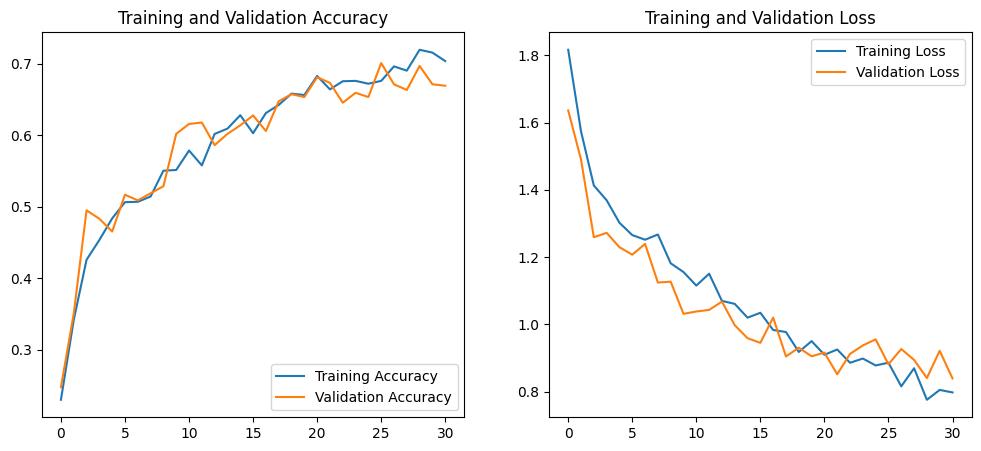

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


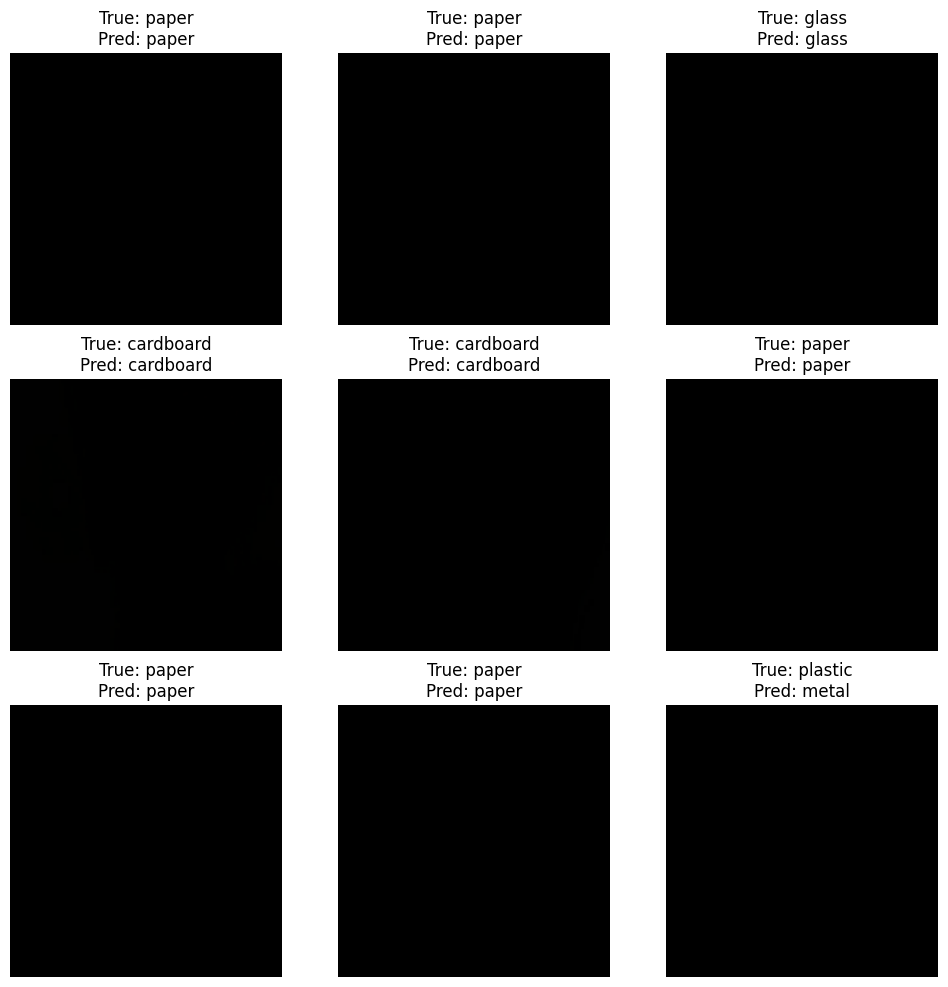

In [ ]:
import numpy as np

# Get one batch from validation set
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = classes[labels[i]]
        pred_label = classes[pred_classes[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models

In [ ]:
base_model = MobileNetV2(
    input_shape = (180, 180, 3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = False

/tmp/ipython-input-3846116695.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [ ]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.3520 - loss: 1.8977 - val_accuracy: 0.6832 - val_loss: 0.8404
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5942 - loss: 1.0789 - val_accuracy: 0.7604 - val_loss: 0.6723
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6694 - loss: 0.9197 - val_accuracy: 0.7782 - val_loss: 0.6240
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7021 - loss: 0.8375 - val_accuracy: 0.7743 - val_loss: 0.5978
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6969 - loss: 0.7998 - val_accuracy: 0.7663 - val_loss: 0.6235
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7445 - loss: 0.6991 - val_accuracy: 0.7881 - val_loss: 0.5756
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7322 - loss: 0.7074 - val_accuracy: 0.7901 - val_loss: 0.5553
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7506 - loss: 0.6947 - val_accuracy: 0.7921 - 

In [ ]:
val_loss,   val_acc = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8340 - loss: 0.4669
Validation Accuracy: 83.76%
Validation Loss: 0.49


In [ ]:
base_model.trainable = True

fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.5165 - loss: 1.6584 - val_accuracy: 0.8277 - val_loss: 0.4871
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5812 - loss: 1.2048 - val_accuracy: 0.8257 - val_loss: 0.4918
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6770 - loss: 0.9126 - val_accuracy: 0.8396 - val_loss: 0.4911
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.7025 - loss: 0.8032 - val_accuracy: 0.8416 - val_loss: 0.4887
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7242 - loss: 0.8062 - val_accuracy: 0.8495 - val_loss: 0.4863
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.7432 - loss: 0.7336 - val_accuracy: 0.8515 - val_loss: 0.4776
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7502 - loss: 0.6361 - val_accuracy: 0.8416 - val_loss: 0.4665
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.7749 - loss: 0.6148 - val_accuracy:

In [ ]:
val_loss,   val_acc = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8416 - loss: 0.4565
Validation Accuracy: 85.15%
Validation Loss: 0.48


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[early_stop, lr_schedule])


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.7504 - loss: 0.6344 - val_accuracy: 0.8436 - val_loss: 0.4657 - learning_rate: 1.0000e-05
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7951 - loss: 0.5754 - val_accuracy: 0.8396 - val_loss: 0.4573 - learning_rate: 1.0000e-05
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.7925 - loss: 0.5481 - val_accuracy: 0.8515 - val_loss: 0.4437 - learning_rate: 1.0000e-05
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.7863 - loss: 0.5779 - val_accuracy: 0.8475 - val_loss: 0.4373 - learning_rate: 1.0000e-05
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.8191 - loss: 0.4749 - val_accuracy: 0.8515 - val_loss: 0.4324 - learning_rate: 1.0000e-05
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8357 - loss: 0.4363 - val_accuracy: 0.8574 - val_loss: 0.4291 - learning_rate: 1.0000e-05
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy

In [ ]:
val_loss,   val_acc = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8569 - loss: 0.4215
Validation Accuracy: 86.34%
Validation Loss: 0.42


In [ ]:
import numpy as np
import  seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


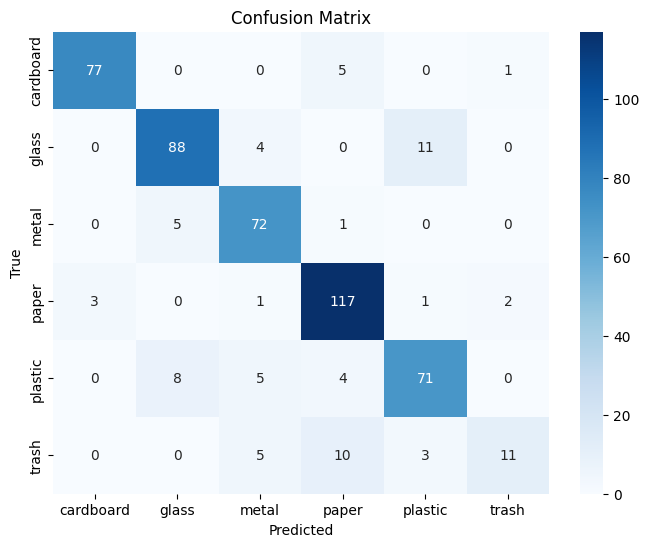

              precision    recall  f1-score   support

   cardboard       0.96      0.93      0.94        83
       glass       0.87      0.85      0.86       103
       metal       0.83      0.92      0.87        78
       paper       0.85      0.94      0.90       124
     plastic       0.83      0.81      0.82        88
       trash       0.79      0.38      0.51        29

    accuracy                           0.86       505
   macro avg       0.85      0.81      0.82       505
weighted avg       0.86      0.86      0.86       505



In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure same length
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),
    y=y_true
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, lr_schedule]
)


{0: np.float64(1.0140562248995983), 1: np.float64(0.8171521035598706), 2: np.float64(1.079059829059829), 3: np.float64(0.678763440860215), 4: np.float64(0.9564393939393939), 5: np.float64(2.9022988505747125)}
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8629 - loss: 0.3566 - val_accuracy: 0.8614 - val_loss: 0.4102 - learning_rate: 5.0000e-06
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.8632 - loss: 0.3658 - val_accuracy: 0.8574 - val_loss: 0.4088 - learning_rate: 5.0000e-06
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8529 - loss: 0.3588 - val_accuracy: 0.8614 - val_loss: 0.4058 - learning_rate: 5.0000e-06
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8446 - loss: 0.3988 - val_accuracy: 0.8634 - val_loss: 0.4033 - learning_rate: 5.0000e-06
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8376 - loss: 0.3791 - val_accuracy: 0.8634 - val_loss: 0.3986 - learning_rate: 5.0000e-06
Epoch 6/5